# Pneumonia Detection CNN usisng pre-trained ResNet18

### Common information

In [12]:
%%python --version

Python 3.11.11


### Importing libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.models import ResNet18_Weights
import matplotlib.pyplot as plt
import os
import kagglehub
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns


### Download the dataset from kaggle

In [2]:

# Download the dataset using kagglehub
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Path to dataset files:", path)


100%|██████████| 2.29G/2.29G [00:25<00:00, 95.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


### Try to use GPU if available

In [3]:
# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Data augmentation setup

In [4]:
# Data transforms with enhanced augmentation
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),  # Rotate by up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness/contrast
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


### Spliting dataset into training, validation & testing

In [5]:
# Load dataset and split train/val
data_dir = os.path.join(path, "chest_xray")
full_train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


### Load pretrained resnet model


In [6]:

# Load ResNet-18 with dropout
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),  #dropout
    nn.Linear(num_ftrs, 2)  # 2 classes: Normal, Pneumonia
)
model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]


### Selecting Loss function and optimizer

In [7]:
# Loss function and optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Weight decay for regularization
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)  # LR scheduler


### Setting up training & testing pipeline

In [8]:
# Training function with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    best_val_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_acc:.2f}%")

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc = 100 * correct / total
        print(f"Validation Accuracy: {val_acc:.2f}%")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print(f"Saved best model with validation accuracy: {best_val_acc:.2f}%")

        scheduler.step()

    return model

# Test the model with confusion matrix
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = 100 * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return test_acc


### Visualizing the final results

In [9]:
# Visualization demo (plot a few predictions)
def visualize_predictions(model, test_loader):
    model.eval()
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images, labels = images[:4].to(device), labels[:4].to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    for i in range(4):
        img = images[i].cpu().permute(1, 2, 0).numpy() * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = img.clip(0, 1)
        axs[i].imshow(img)
        axs[i].set_title(f"Pred: {preds[i].item()}, True: {labels[i].item()}")
        axs[i].axis("off")
    plt.show()


### Training, testing and visualizing the results

Epoch 1, Loss: 0.2035, Train Accuracy: 92.69%
Validation Accuracy: 94.54%
Saved best model with validation accuracy: 94.54%
Epoch 2, Loss: 0.1308, Train Accuracy: 95.18%
Validation Accuracy: 82.28%
Epoch 3, Loss: 0.0925, Train Accuracy: 96.50%
Validation Accuracy: 97.70%
Saved best model with validation accuracy: 97.70%
Epoch 4, Loss: 0.0702, Train Accuracy: 97.32%
Validation Accuracy: 97.22%
Epoch 5, Loss: 0.0710, Train Accuracy: 97.56%
Validation Accuracy: 97.51%
Epoch 6, Loss: 0.0692, Train Accuracy: 97.24%
Validation Accuracy: 97.70%
Epoch 7, Loss: 0.0672, Train Accuracy: 97.75%
Validation Accuracy: 97.99%
Saved best model with validation accuracy: 97.99%
Epoch 8, Loss: 0.0653, Train Accuracy: 97.65%
Validation Accuracy: 97.13%
Epoch 9, Loss: 0.0596, Train Accuracy: 97.82%
Validation Accuracy: 97.51%
Epoch 10, Loss: 0.0625, Train Accuracy: 97.75%
Validation Accuracy: 98.18%
Saved best model with validation accuracy: 98.18%
Loading best model for testing...


<ipython-input-10-6bf22fc987c0>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Test Accuracy: 94.71%


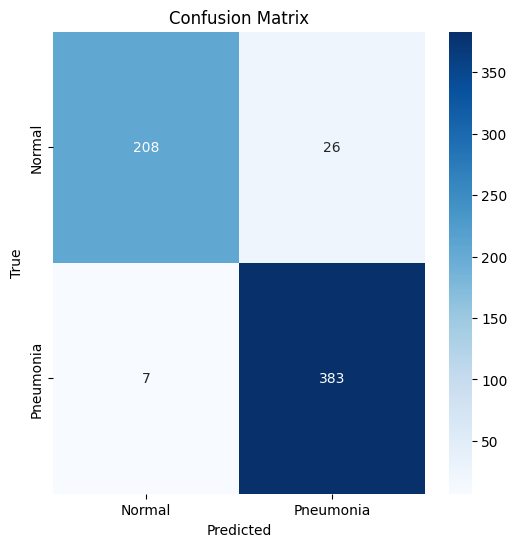

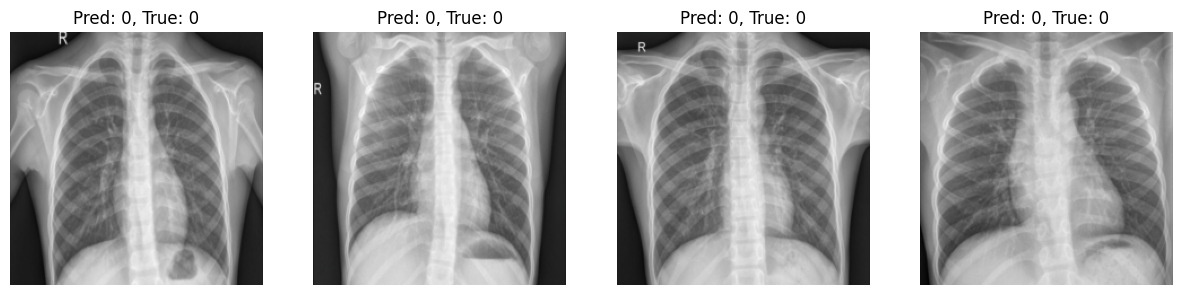

In [10]:
# Train and evaluate
model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10)
print("Loading best model for testing...")
model.load_state_dict(torch.load("best_model.pth"))
model = model.to(device)

test_acc = test_model(model, test_loader)
visualize_predictions(model, test_loader)


### Setup JIT optimized model and saving it

In [11]:
# Save JIT-optimized model
model.eval()
example_input = torch.randn(1, 3, 224, 224).to(device)
traced_model = torch.jit.trace(model, example_input)
traced_model.save("pneumonia_model_jit.pt")
print("JIT-optimized model saved as pneumonia_model_jit.pt")

JIT-optimized model saved as pneumonia_model_jit.pt
